In [38]:
import os
import random
from collections import Counter
from datetime import datetime

import pandas as pd
from matplotlib import pyplot as plt, font_manager, rcParams

# Aksara font
FONT_PATH = "./fonts/Noto_Sans_Javanese/static/NotoSansJavanese-Regular.ttf"
font_manager.fontManager.addfont(FONT_PATH)
rcParams["font.family"] = font_manager.FontProperties(fname=FONT_PATH).get_name()


In [39]:
TOTAL_SAMPLE = 1000

CSV_PATH = (
    "./data/word_nglegena_"
    f"{datetime.now().strftime('%Y%m%d_%H%M%S')}"
    "/label.csv"
)

CONFIG = {
    "min_word": 2,
    "max_word": 6,
}

NGLEGENA = [
    ("ꦲ","ha"), ("ꦤ","na"), ("ꦕ","ca"), ("ꦫ","ra"), ("ꦏ","ka"),
    ("ꦢ","da"), ("ꦠ","ta"), ("ꦱ","sa"), ("ꦮ","wa"), ("ꦭ","la"),
    ("ꦥ","pa"), ("ꦝ","dha"), ("ꦗ","ja"), ("ꦪ","ya"), ("ꦚ","nya"),
    ("ꦩ","ma"), ("ꦒ","ga"), ("ꦧ","ba"), ("ꦛ","tha"), ("ꦔ","nga"),
]


In [40]:
def generate_word(cfg, coverage):
    lengths = list(range(cfg["min_word"], cfg["max_word"] + 1))
    len_weights = [
        1.0 / (coverage["word"][l] + 1.0)
        for l in lengths
    ]
    length = random.choices(lengths, weights=len_weights, k=1)[0]

    jawa, latin = "", ""

    for _ in range(length):
        # weighted aksara
        aks_weights = [
            1.0 / (coverage["aksara"][aks] + 1.0)
            for aks, _ in NGLEGENA
        ]
        aks, lat = random.choices(NGLEGENA, weights=aks_weights, k=1)[0]

        jawa += aks
        latin += lat
        coverage["aksara"][aks] += 1

    coverage["word"][length] += 1
    return jawa, latin, length



def generate_dataset(total, cfg, coverage):
    rows = []

    for i in range(total):
        jawa, latin, length = generate_word(cfg, coverage)
        rows.append({
            "image": f"img_{i:05d}.png",
            "transcription": jawa,
            "transliteration": latin,
            "length": length,
        })

    return pd.DataFrame(rows)


In [41]:
coverage = {
    "aksara": Counter({aks: 0 for aks, _ in NGLEGENA}),
    "word": Counter()
}
df = generate_dataset(TOTAL_SAMPLE, CONFIG, coverage)

allowed = set(dict(NGLEGENA).keys())
violations = [
    {
        "index": idx,
        "kata": word,
        "detail": f"Karakter ilegal: {ch}",
    }
    for idx, word in enumerate(df["transcription"])
    for ch in word
    if ch not in allowed
]
violations_df = pd.DataFrame(violations)
print("\nPelanggaran ortografi:", len(violations_df))

os.makedirs(os.path.dirname(CSV_PATH), exist_ok=True)
df.to_csv(CSV_PATH, index=False)
print(f"Dataset tersimpan: {CSV_PATH}")



Pelanggaran ortografi: 0
Dataset tersimpan: ./data/word_nglegena_20260102_134410/label.csv


RINGKASAN DATA
Total kata            : 1000
Min panjang kata      : 2
Max panjang kata      : 6
Rata-rata panjang     : 3.97

DISTRIBUSI PANJANG KATA
 2 aksara |   201 kata |  20.10%
 3 aksara |   210 kata |  21.00%
 4 aksara |   200 kata |  20.00%
 5 aksara |   193 kata |  19.30%
 6 aksara |   196 kata |  19.60%


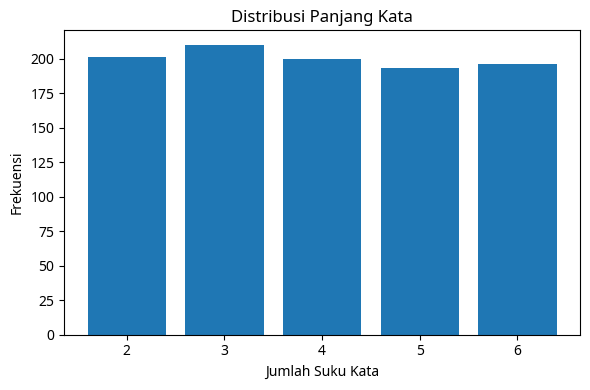

DISTRIBUSI AKSARA
  ꦲ (ha ) |    208 |   5.24%
  ꦤ (na ) |    196 |   4.93%
  ꦕ (ca ) |    203 |   5.11%
  ꦫ (ra ) |    204 |   5.13%
  ꦏ (ka ) |    190 |   4.78%
  ꦢ (da ) |    202 |   5.08%
  ꦠ (ta ) |    205 |   5.16%
  ꦱ (sa ) |    198 |   4.98%
  ꦮ (wa ) |    203 |   5.11%
  ꦭ (la ) |    196 |   4.93%
  ꦥ (pa ) |    201 |   5.06%
  ꦝ (dha) |    193 |   4.86%
  ꦗ (ja ) |    193 |   4.86%
  ꦪ (ya ) |    191 |   4.81%
  ꦚ (nya) |    201 |   5.06%
  ꦩ (ma ) |    188 |   4.73%
  ꦒ (ga ) |    205 |   5.16%
  ꦧ (ba ) |    195 |   4.91%
  ꦛ (tha) |    205 |   5.16%
  ꦔ (nga) |    196 |   4.93%

Total aksara: 3973


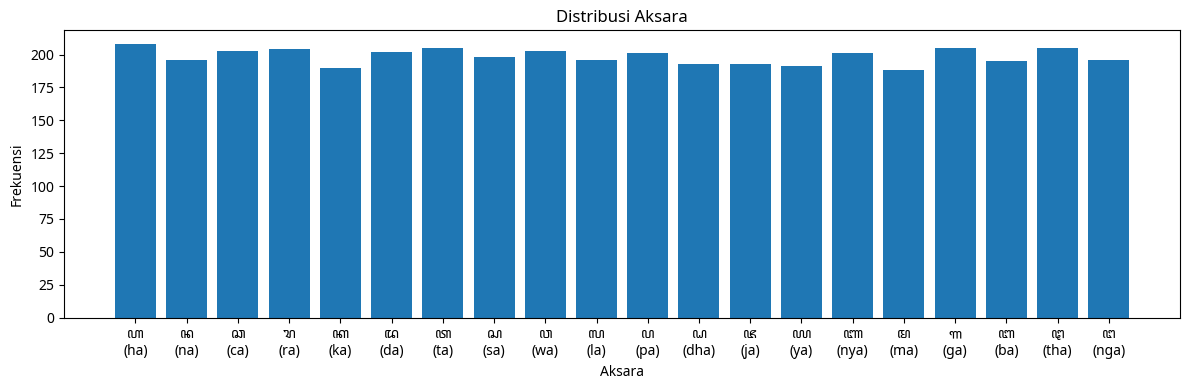

In [42]:
def plot_bar(x, y, title, xlabel, ylabel, figsize):
    plt.figure(figsize=figsize)
    plt.bar(x, y)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()



# =========================================================
# DATA SUMMARY
# =========================================================
print("=" * 40)
print("RINGKASAN DATA")
print("=" * 40)

print(
    f"Total kata            : {len(df)}\n"
    f"Min panjang kata      : {df['length'].min()}\n"
    f"Max panjang kata      : {df['length'].max()}\n"
    f"Rata-rata panjang     : {df['length'].mean():.2f}\n"
)


# =========================================================
# WORD LENGTH DISTRIBUTION
# =========================================================
print("=" * 40)
print("DISTRIBUSI PANJANG KATA")
print("=" * 40)

length_dist = df["length"].value_counts().sort_index()
total_words = len(df)

for length, count in length_dist.items():
    pct = count / total_words * 100
    print(f"{length:>2} aksara | {count:5d} kata | {pct:6.2f}%")

plot_bar(
    length_dist.index,
    length_dist.values,
    "Distribusi Panjang Kata",
    "Jumlah Suku Kata",
    "Frekuensi",
    (6, 4),
)


# =========================================================
# AKSARA DISTRIBUTION
# =========================================================
print("=" * 40)
print("DISTRIBUSI AKSARA")
print("=" * 40)

latin_map = {aks: lat for aks, lat in NGLEGENA}
aksara_dist = pd.DataFrame(
    [(aks, coverage["aksara"][aks]) for aks, _ in NGLEGENA],
    columns=["aksara", "count"],
).assign(
    latin=lambda df: df["aksara"].map(latin_map)
)

total_aksara = aksara_dist["count"].sum()
for _, row in aksara_dist.iterrows():
    pct = (row["count"] / total_aksara * 100) if total_aksara else 0
    print(
        f"{row['aksara']:>3} ({row['latin']:<3}) | "
        f"{row['count']:6d} | {pct:6.2f}%"
    )

print(f"\nTotal aksara: {total_aksara}")
plot_bar(
    [f"{a}\n({latin_map[a]})" for a in aksara_dist["aksara"]],
    aksara_dist["count"],
    "Distribusi Aksara",
    "Aksara",
    "Frekuensi",
    (12, 4),
)
